Starting analysis with 10 runs per model variant...
Network parameters: n=1000, m0=10, m=3
Running experiments with alpha=1.0...


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Running experiments with alpha=2.0...


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Running experiments with alpha=3.0...


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Running experiments with alpha=4.0...


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Creating visualizations...
Analyzing results...

Summary of Network Metrics by Alpha Value:
      max_degree         avg_degree        degree_variance           \
            mean     std       mean    std            mean      std   
alpha                                                                 
1.0      108.000  12.356      6.030  0.000          65.558    5.896   
2.0      815.000  87.175      6.030  0.000        1659.223  278.185   
3.0      980.000   9.707      6.030  0.000        2710.143   90.617   
4.0      991.300   4.057      6.030  0.000        2857.898   46.266   

      gini_coefficient        avg_clustering        char_path_length         \
                  mean    std           mean    std             mean    std   
alpha                                                                         
1.0              0.381  0.006          0.047  0.007            3.383  0.039   
2.0              0.499  0.000          0.937  0.009            2.056  0.045   
3.0            

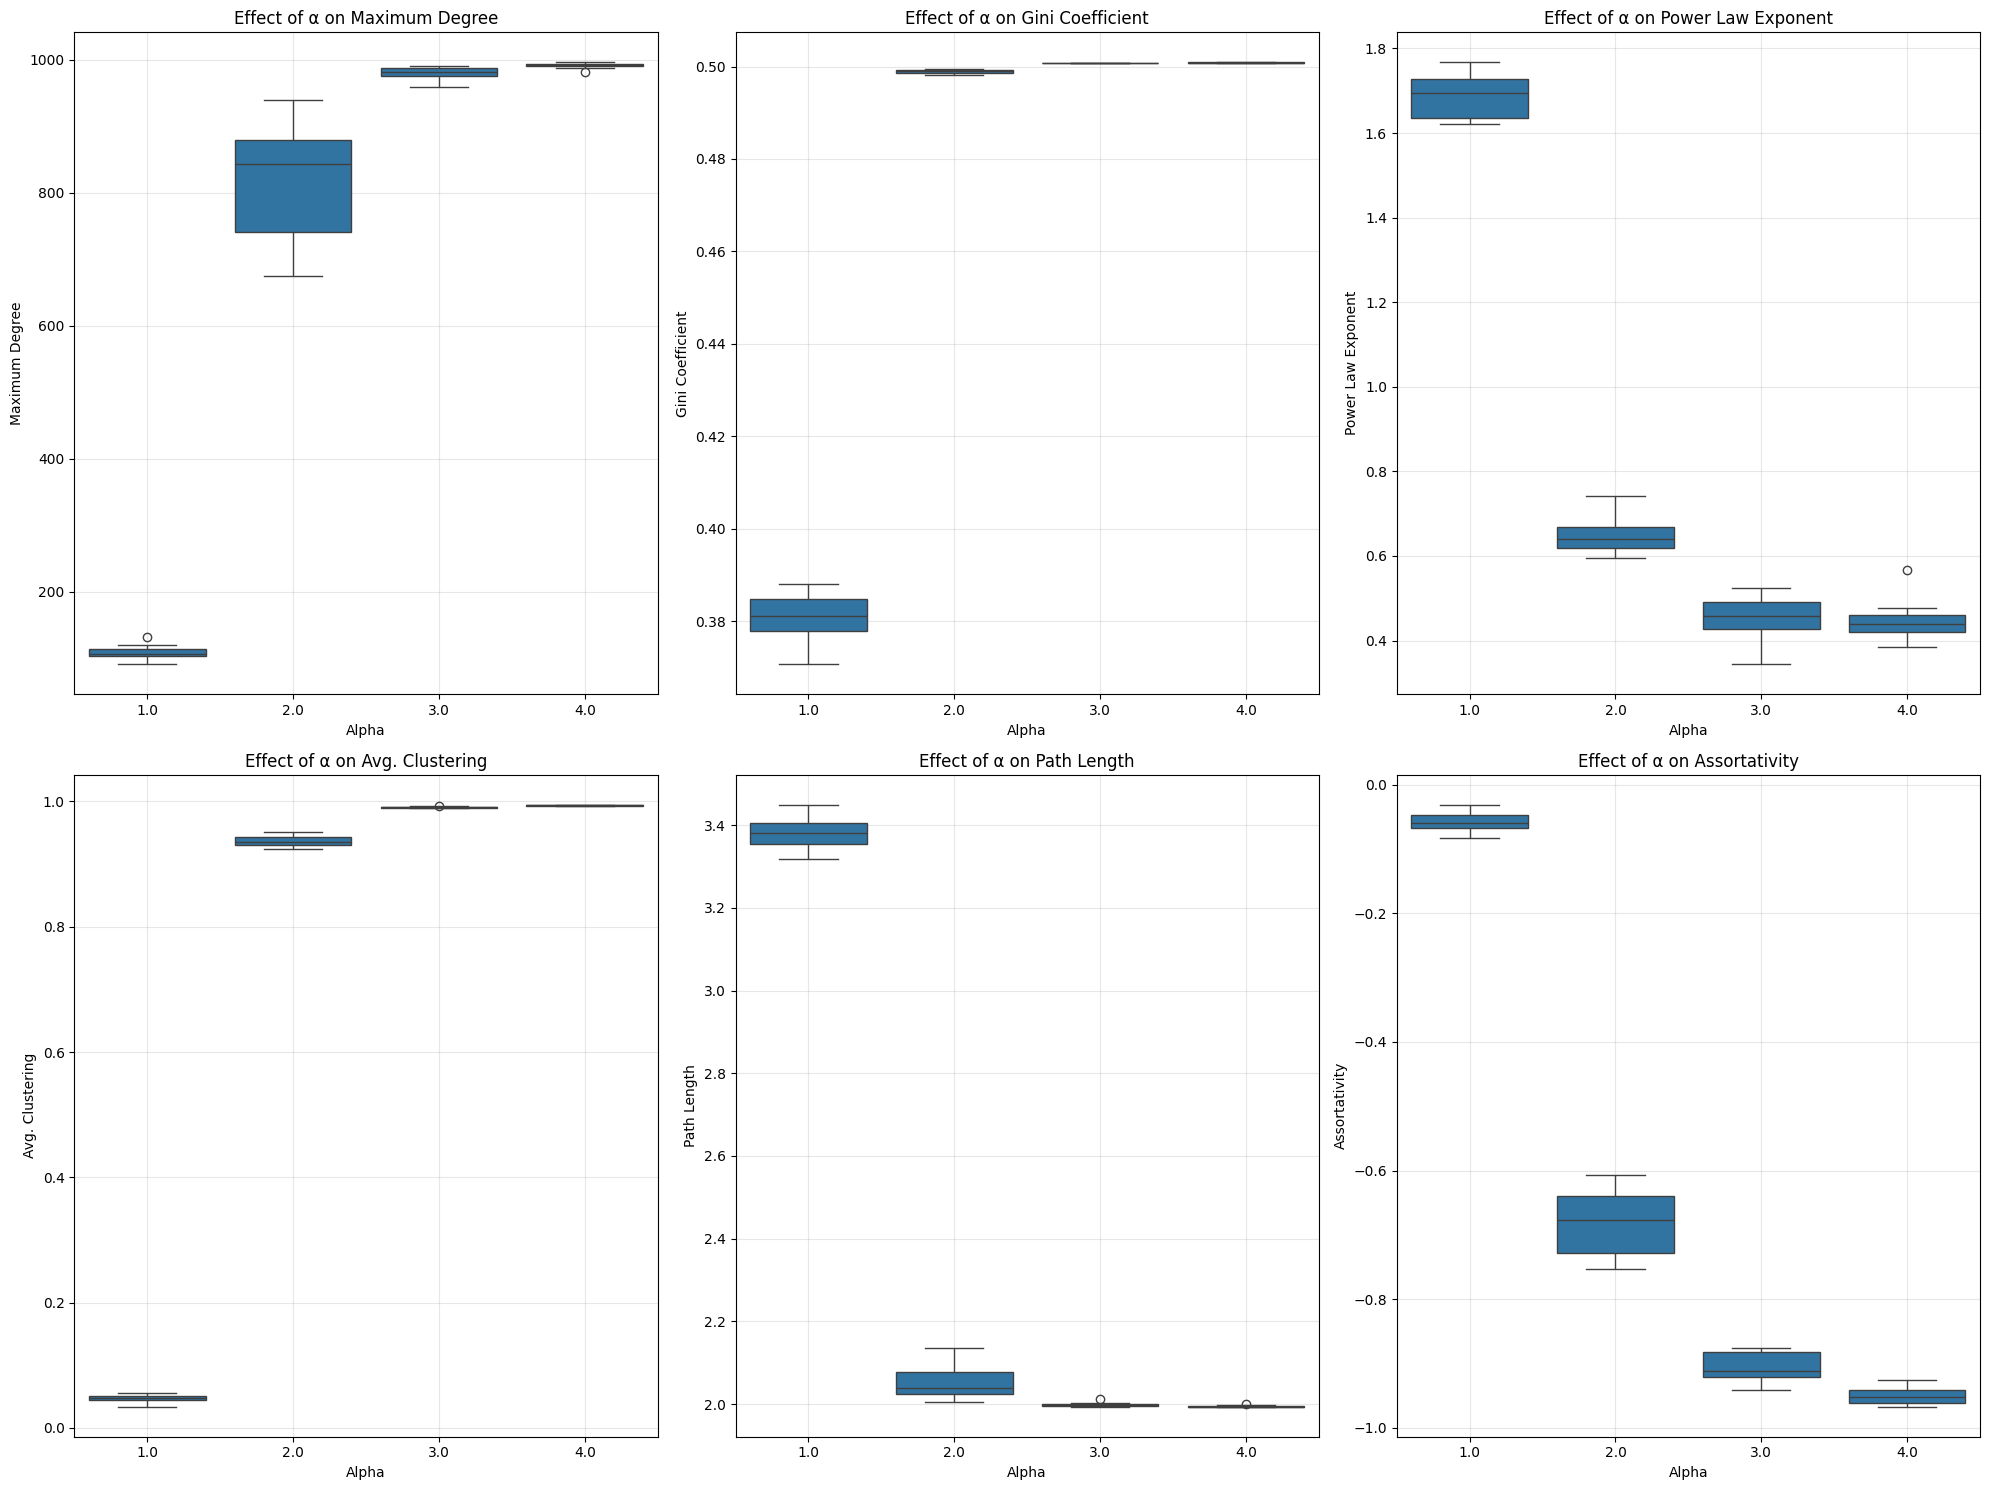

In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def generalized_barabasi_albert(initial_nodes, final_nodes, edges_per_step, alpha=1.0):
    """
    Implement a generalized Barabási-Albert model with enhanced preferential attachment.
    
    Parameters:
    -----------
    initial_nodes : int
        Number of nodes in the initial random network
    final_nodes : int
        Total number of nodes in the final network
    edges_per_step : int
        Number of edges to add with each new node
    alpha : float
        Exponent for preferential attachment. 
        alpha=1.0 is standard BA model, 
        alpha=2.0 is "square of degree", 
        higher values create stronger "rich get richer" effects
    
    Returns:
    --------
    G : networkx.Graph
        The generated network
    """
    # Create initial network (complete graph)
    G = nx.complete_graph(initial_nodes)
    
    # Add nodes according to generalized preferential attachment
    for i in range(initial_nodes, final_nodes):
        # Get all existing nodes and their degrees
        nodes = list(G.nodes())
        degrees = [G.degree(node) for node in nodes]
        
        # Apply the power law exponent alpha to the degrees
        weighted_degrees = [degree**alpha for degree in degrees]
        
        # Calculate probabilities based on weighted degrees
        total_weighted_degree = sum(weighted_degrees)
        if total_weighted_degree == 0:  # Handle edge case
            probabilities = [1.0/len(nodes) for _ in nodes]  # Uniform if all degrees are 0
        else:
            probabilities = [w_degree / total_weighted_degree for w_degree in weighted_degrees]
        
        # Choose edges_per_step nodes based on preferential attachment
        # Handle case where edges_per_step > number of eligible nodes
        if edges_per_step >= len(nodes):
            targets = nodes
        else:
            targets = np.random.choice(nodes, size=edges_per_step, replace=False, p=probabilities)
        
        # Add new node and connect to targets
        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)
    
    return G

def gini_coefficient(x):
    """
    Calculate the Gini coefficient of a distribution
    A measure of inequality (0 = perfect equality, 1 = perfect inequality)
    """
    # Sort values
    sorted_x = np.sort(x)
    n = len(sorted_x)
    # Calculate cumulative sum
    cumsum = np.cumsum(sorted_x)
    # Calculate Gini coefficient
    return (n + 1 - 2 * np.sum(cumsum) / (cumsum[-1])) / n if cumsum[-1] > 0 else 0

def analyze_network(G):
    """
    Analyze network topology
    
    Parameters:
    -----------
    G : networkx.Graph
        The network to analyze
    
    Returns:
    --------
    dict
        Dictionary containing the analysis results
    """
    results = {}
    
    # Basic metrics
    results['nodes'] = G.number_of_nodes()
    results['edges'] = G.number_of_edges()
    results['avg_clustering'] = nx.average_clustering(G)
    
    # Degree metrics
    degrees = [G.degree(n) for n in G.nodes()]
    results['max_degree'] = max(degrees)
    results['avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()
    results['degree_variance'] = np.var(degrees)
    results['gini_coefficient'] = gini_coefficient(degrees)
    
    # Degree distribution
    degree_counts = Counter(degrees)
    results['degree_distribution'] = degree_counts
    
    # Path metrics - handle disconnected graphs
    if nx.is_connected(G):
        results['char_path_length'] = nx.average_shortest_path_length(G)
        results['network_diameter'] = nx.diameter(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        largest_subgraph = G.subgraph(largest_cc)
        results['char_path_length'] = nx.average_shortest_path_length(largest_subgraph)
        results['network_diameter'] = nx.diameter(largest_subgraph)
        results['largest_component_ratio'] = len(largest_cc) / G.number_of_nodes()
    
    # Power law fit
    try:
        unique_degrees = sorted(set(degrees))
        counts = [degree_counts[d] for d in unique_degrees]
        pk = [c/sum(counts) for c in counts]  # Convert to probability
        
        # Filter zeros for log regression
        valid_indices = [i for i, p in enumerate(pk) if p > 0]
        valid_k = [unique_degrees[i] for i in valid_indices]
        valid_pk = [pk[i] for i in valid_indices]
        
        if len(valid_k) > 5:
            # Log-log regression
            log_k = np.log(valid_k)
            log_pk = np.log(valid_pk)
            coeffs = np.polyfit(log_k, log_pk, 1)
            results['power_law_exponent'] = -coeffs[0]  # Negative of slope
        else:
            results['power_law_exponent'] = None
    except:
        results['power_law_exponent'] = None
    
    # Centralization metrics
    try:
        # Degree centrality
        degree_centrality = nx.degree_centrality(G)
        max_centrality = max(degree_centrality.values())
        sum_diff = sum(max_centrality - c for c in degree_centrality.values())
        n = G.number_of_nodes()
        # Normalization factor for degree centralization
        normalization = (n-1)*(n-2)/(n-1)
        results['degree_centralization'] = sum_diff / normalization if normalization > 0 else 0
    except:
        results['degree_centralization'] = None
    
    # Assortativity coefficient (degree correlation)
    try:
        results['assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        results['assortativity'] = None
    
    return results

def plot_degree_distribution(degree_counts, alpha, filename=None):
    """
    Plot the degree distribution on a log-log scale with CCDF.
    
    Parameters:
    -----------
    degree_counts : Counter
        Counts of each degree value
    alpha : float
        Alpha value used to generate the network
    filename : str, optional
        Output file name, if None the plot is displayed but not saved
    """
    degrees = sorted(degree_counts.keys())
    counts = [degree_counts[d] for d in degrees]
    total_nodes = sum(counts)
    
    # Calculate CCDF (complementary cumulative distribution function)
    ccdf = []
    for d in degrees:
        nodes_with_degree_geq_d = sum(count for deg, count in degree_counts.items() if deg >= d)
        ccdf.append(nodes_with_degree_geq_d / total_nodes)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(degrees, ccdf, 'bo-', markersize=6, alpha=0.7, label='CCDF P(k≥x)')
    
    # Add power law fit line
    if len(degrees) > 5 and min(degrees) > 0:
        # Clean data for fitting (log-log)
        log_k = np.log(degrees)
        log_ccdf = np.log(ccdf)
        
        # Fit line to log-log data
        coeffs = np.polyfit(log_k, log_ccdf, 1)
        gamma = -coeffs[0]
        
        # Plot fit line
        x_range = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 100)
        y_fit = np.exp(coeffs[1]) * x_range**coeffs[0]
        plt.loglog(x_range, y_fit, 'r-', label=f'Power law fit: γ≈{gamma:.2f}')
    
    plt.xlabel('Degree k (log scale)')
    plt.ylabel('P(K ≥ k) (log scale)')
    plt.title(f'Degree Distribution (CCDF) with α={alpha:.1f}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def visualize_network(G, alpha, filename=None):
    """
    Visualize the network with node sizes based on degree.
    
    Parameters:
    -----------
    G : networkx.Graph
        The network to visualize
    alpha : float
        Alpha value used to generate the network
    filename : str, optional
        Output file name, if None the plot is displayed but not saved
    """
    # If network is large, take a sample for better visualization
    if G.number_of_nodes() > 150:
        nodes = sorted(G.nodes())
        sampled_nodes = sorted(np.random.choice(nodes, 150, replace=False))
        G_vis = G.subgraph(sampled_nodes)
    else:
        G_vis = G

    fig, ax = plt.subplots(figsize=(12, 10))  # Create figure and axes explicitly
    
    # Use spring layout with consistent seed
    pos = nx.spring_layout(G_vis, k=0.2, seed=42)
    
    # Node sizes based on degree
    degrees = dict(G_vis.degree())
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [20 + 1000 * (degrees[node] / max_degree) for node in G_vis.nodes()]
    
    # Node colors based on degree
    node_colors = [degrees[node] for node in G_vis.nodes()]
    
    # Draw network
    nodes = nx.draw_networkx_nodes(
        G_vis, pos, 
        node_size=node_sizes, 
        node_color=node_colors,
        cmap=plt.cm.viridis,
        alpha=0.7,
        ax=ax
    )
    
    nx.draw_networkx_edges(
        G_vis, pos,
        edge_color='gray',
        width=0.3,
        alpha=0.5,
        ax=ax
    )
    
    # Fix for colorbar - create a mappable with properly set norm
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Node Degree')
    
    plt.title(f'Network with α={alpha:.1f} (N={G.number_of_nodes()}, m={G.number_of_edges()/G.number_of_nodes():.1f})')
    plt.axis('off')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()
        
def run_experiments(final_nodes=1000, initial_nodes=10, edges_per_step=3, runs_per_model=10):
    """
    Run experiments comparing different alpha values for the generalized BA model
    
    Parameters:
    -----------
    final_nodes : int
        Size of the final networks
    initial_nodes : int
        Size of the initial complete graph
    edges_per_step : int
        Number of edges added with each new node
    runs_per_model : int
        Number of networks to generate for each model variant
    
    Returns:
    --------
    tuple(DataFrame, dict)
        Results from all experiments and a dictionary of example networks
    """
    # Alpha values to test (1.0 is standard BA, 2.0 is square, 3.0 is cube, etc.)
    alpha_values = [1.0, 2.0, 3.0, 4.0]
    results = []
    example_networks = {}
    
    for alpha in alpha_values:
        print(f"Running experiments with alpha={alpha}...")
        
        for run in tqdm(range(runs_per_model)):
            # Generate network
            G = generalized_barabasi_albert(initial_nodes, final_nodes, edges_per_step, alpha)
            
            # Save first run as example for visualization
            if run == 0:
                example_networks[alpha] = G
            
            # Analyze network
            analysis = analyze_network(G)
            
            # Store results with alpha and run information
            result = {
                'alpha': alpha,
                'run': run,
                **{k: v for k, v in analysis.items() if k != 'degree_distribution'}
            }
            
            results.append(result)
    
    return pd.DataFrame(results), example_networks

def plot_metric_vs_alpha(results_df, metric, title, ylabel, filename=None):
    """
    Create a boxplot showing how a metric changes with alpha
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results dataframe
    metric : str
        Column name of the metric to plot
    title : str
        Plot title
    ylabel : str
        Y-axis label
    filename : str, optional
        Output file name
    """
    plt.figure(figsize=(10, 6))
    
    # Create boxplot
    sns.boxplot(x='alpha', y=metric, data=results_df)
    
    # Add individual points for better visibility
    sns.stripplot(x='alpha', y=metric, data=results_df, 
                  color='black', size=4, alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Alpha (Preferential Attachment Exponent)')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    
    if filename:
        plt.savefig(filename, dpi=300)
        plt.close()
    else:
        plt.show()

def create_summary_table(results_df):
    """
    Create a summary table of metrics by alpha value
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results from experiments
    
    Returns:
    --------
    pandas.DataFrame
        Summary table with means and standard deviations
    """
    # Select key metrics
    metrics = [
        'max_degree', 'avg_degree', 'degree_variance', 'gini_coefficient',
        'avg_clustering', 'char_path_length', 'power_law_exponent',
        'assortativity', 'degree_centralization'
    ]
    
    # Group by alpha and compute mean and std
    summary = results_df.groupby('alpha')[metrics].agg(['mean', 'std'])
    
    return summary

def main(final_nodes=1000, initial_nodes=10, edges_per_step=3, runs_per_model=10):
    """
    Main function to run the complete analysis
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    print(f"Starting analysis with {runs_per_model} runs per model variant...")
    print(f"Network parameters: n={final_nodes}, m0={initial_nodes}, m={edges_per_step}")
    
    # Run experiments
    results_df, example_networks = run_experiments(
        final_nodes=final_nodes,
        initial_nodes=initial_nodes, 
        edges_per_step=edges_per_step,
        runs_per_model=runs_per_model
    )
    
    # Plot network visualizations and degree distributions for each alpha
    print("Creating visualizations...")
    for alpha, G in example_networks.items():
        # Analyze to get degree distribution
        analysis = analyze_network(G)
        
        # Plot and save degree distribution
        plot_degree_distribution(
            analysis['degree_distribution'], 
            alpha,
            f"degree_distribution_alpha_{alpha}.png"
        )
        
        # Plot and save network visualization
        visualize_network(
            G, 
            alpha,
            f"network_visualization_alpha_{alpha}.png"
        )
    
    # Create metric plots
    print("Analyzing results...")
    plot_metric_vs_alpha(
        results_df, 
        'max_degree', 
        'Effect of Alpha on Maximum Degree',
        'Maximum Node Degree',
        'max_degree_vs_alpha.png'
    )
    
    plot_metric_vs_alpha(
        results_df, 
        'gini_coefficient', 
        'Effect of Alpha on Degree Inequality',
        'Gini Coefficient',
        'gini_vs_alpha.png'
    )
    
    plot_metric_vs_alpha(
        results_df, 
        'power_law_exponent', 
        'Effect of Alpha on Power Law Exponent',
        'Power Law Exponent (γ)',
        'power_law_vs_alpha.png'
    )
    
    plot_metric_vs_alpha(
        results_df, 
        'avg_clustering', 
        'Effect of Alpha on Clustering',
        'Average Clustering Coefficient',
        'clustering_vs_alpha.png'
    )
    
    plot_metric_vs_alpha(
        results_df, 
        'char_path_length', 
        'Effect of Alpha on Path Length',
        'Characteristic Path Length',
        'path_length_vs_alpha.png'
    )
    
    # Create summary figure
    plt.figure(figsize=(20, 15))
    
    metrics = [
        ('max_degree', 'Maximum Degree'), 
        ('gini_coefficient', 'Gini Coefficient'),
        ('power_law_exponent', 'Power Law Exponent'),
        ('avg_clustering', 'Avg. Clustering'),
        ('char_path_length', 'Path Length'),
        ('assortativity', 'Assortativity')
    ]
    
    for i, (metric, title) in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='alpha', y=metric, data=results_df)
        plt.title(f'Effect of α on {title}')
        plt.xlabel('Alpha')
        plt.ylabel(title)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('summary_metrics.png', dpi=300)
    
    # Create and display summary table
    summary_table = create_summary_table(results_df)
    
    # Save results to CSV
    results_df.to_csv('modified_ba_results.csv', index=False)
    summary_table.to_csv('modified_ba_summary.csv')
    
    # Print summary
    print("\nSummary of Network Metrics by Alpha Value:")
    print("===========================================")
    
    # Format the summary table for printing
    formatted_summary = summary_table.copy()
    for col in formatted_summary.columns:
        if col[0] != 'power_law_exponent':
            formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:.3f}")
        else:
            formatted_summary[col] = formatted_summary[col].map(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
    
    print(formatted_summary)
    
    # Final key findings
    print("\nKey Findings:")
    print("1. As alpha increases (stronger rich-get-richer effect):")
    
    # Calculate average values for alpha=1 and alpha=2 for comparison
    alpha1_stats = results_df[results_df['alpha'] == 1.0].mean()
    alpha2_stats = results_df[results_df['alpha'] == 2.0].mean()
    
    # Calculate percentage increases
    pct_change_max_degree = (alpha2_stats['max_degree'] / alpha1_stats['max_degree'] - 1) * 100
    pct_change_gini = (alpha2_stats['gini_coefficient'] / alpha1_stats['gini_coefficient'] - 1) * 100
    
    print(f"   - Maximum degree increases dramatically (~{pct_change_max_degree:.1f}% higher for α=2 vs α=1)")
    print(f"   - Network inequality (Gini) increases (~{pct_change_gini:.1f}% higher for α=2 vs α=1)")
    print("   - Power law exponent decreases (heavier tail in degree distribution)")
    print("   - Network becomes more centralized around hubs")
    
    print("\n2. For alpha = 2.0 (the case specified in the problem):")
    alpha2_results = results_df[results_df['alpha'] == 2.0].mean()
    print(f"   - Gini coefficient: {alpha2_results['gini_coefficient']:.3f}")
    print(f"   - Power law exponent: {alpha2_results['power_law_exponent']:.3f}")
    print(f"   - Maximum degree: {alpha2_results['max_degree']:.1f}")
    print(f"   - Avg. clustering: {alpha2_results['avg_clustering']:.3f}")
    
    print("\nAnalysis complete.")
    return results_df, summary_table, example_networks

# Run the complete analysis
if __name__ == "__main__":
    results, summary, networks = main(
        final_nodes=1000, 
        initial_nodes=10, 
        edges_per_step=3, 
        runs_per_model=10
    )